In [337]:
import numpy as np

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

import tensorflow as tf

import matplotlib.pyplot as plt

from keras.datasets import mnist

In [338]:
rng = np.random.RandomState(42)

In [339]:
def prepare_mnist_mlfetch():
    (x_train, x_trainLabels), (x_test, x_testLabels) = mnist.load_data()
    labels = x_trainLabels
    data = x_train

    ## 4859 digit- 4
    k_four = np.where(labels == 4)
    label_four = labels[k_four]
    data_four = data[k_four]

    k_zeros = np.where(labels == 0)
    k_sevens = np.where(labels == 7)
    k_nine = np.where(labels == 9)

    ## 265 (0,7,9)
    label_zeros = labels[k_zeros]
    data_zeros = data[k_zeros]

    label_sevens = labels[k_sevens]
    data_sevens = data[k_sevens]

    label_nine = labels[k_nine]
    data_nines = data[k_nine]


    data_four = data_four[:220]

    data_zeros = data_zeros[:5]
    data_sevens = data_sevens[:3]
    data_nines = data_nines[:3]

    data_sevens = data_sevens[:11]

    normal = data_four
    anomalies = np.concatenate((data_zeros, data_sevens, data_nines), axis=0)


    normal = np.reshape(normal, (len(normal), 784))
    anomalies = np.reshape(anomalies, (len(anomalies), 784))

    return [normal, anomalies]

In [340]:
def sklearn_IsolationForest(data_train, data_test):
    clf = IsolationForest(max_samples=50, random_state=rng)
    clf.fit(data_train)
    pos_decisionScore = clf.predict(data_train)
    neg_decisionScore = clf.predict(data_test)
    
    return [pos_decisionScore, neg_decisionScore]

In [341]:
def sklearn_OCSVM_linear(data_train, data_test, nu):
    ocSVM = OneClassSVM(nu = nu, kernel = 'linear')
    ocSVM.fit(data_train)
    pos_decisionScore = ocSVM.decision_function(data_train)
    neg_decisionScore = ocSVM.decision_function(data_test)
    
    return [pos_decisionScore, neg_decisionScore]

In [342]:
def au_roc(y_true, y_score):
    roc_score = roc_auc_score(y_true, y_score)
    print('ROC  score: {0:0.4f}'.format(roc_score))
    
    return roc_score

In [343]:
def au_prc(y_true, y_score):
    average_precision = average_precision_score(y_true, y_score)
    print('Average precision-recall score: {0:0.4f}'.format(average_precision))
    
    return average_precision

In [344]:
y_true_pos = np.ones(X_train.shape[0])
y_true_neg = np.zeros(X_test.shape[0])
y_true = np.concatenate((y_true_pos, y_true_neg))

In [345]:
[X_train, X_test] = prepare_mnist_mlfetch()

In [346]:
[y_scores_pos_IF, y_scores_neg_IF] = sklearn_IsolationForest(X_train, X_test)

y_score_IF = np.concatenate((y_scores_pos_IF, y_scores_neg_IF))

isolation_forest_roc = au_roc(y_true, y_score_IF)
isolation_forest_prc = au_prc(y_true, y_score_IF)

ROC  score: 0.6773
Average precision-recall score: 0.9688


In [347]:
nu = 0.04

In [348]:
[y_scores_pos_OCSVM_linear, y_scores_neg_OCSVM_linear] = sklearn_OCSVM_linear(X_train, X_test, nu)

y_score_OCSVM_linear = np.concatenate((y_scores_pos_OCSVM_linear, y_scores_neg_OCSVM_linear))

OCSVM_linear_roc = au_roc(y_true, y_score_OCSVM_linear)
OCSVM_linear_prc = au_prc(y_true, y_score_OCSVM_linear)

ROC  score: 0.5740
Average precision-recall score: 0.9686


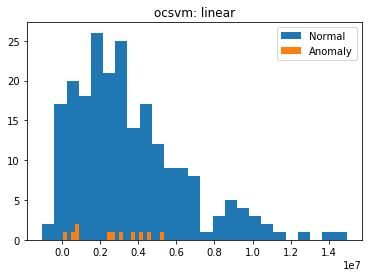

In [349]:
plt.hist(y_scores_pos_OCSVM_linear, bins = 25, label = 'Normal')
plt.hist(y_scores_neg_OCSVM_linear, bins = 25, label = 'Anomaly')
plt.title("ocsvm: linear");
plt.legend(loc='upper right')
plt.show()

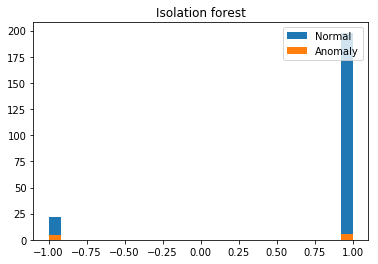

In [350]:
plt.hist(y_scores_pos_IF, bins = 25, label = 'Normal')
plt.hist(y_scores_neg_IF, bins = 25, label = 'Anomaly')
plt.title("Isolation forest");
plt.legend(loc='upper right')
plt.show()

In [351]:
def tf_OneClass_NN_sigmoid(data_train, data_test):
    tf.reset_default_graph()

    train_X = data_train

    RANDOM_SEED = 42
    tf.set_random_seed(RANDOM_SEED)

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 32                 # Number of hidden nodes
    y_size = 1                  # Number of outcomes (3 iris flowers)
    D = x_size
    K = h_size

    theta = np.random.normal(0, 1, K + K*D + 1)
    rvalue = np.random.normal(0, 1, (len(train_X), y_size))
    nu = 0.04

    def init_weights(shape):
        """ Weight initialization """
        weights = tf.random_normal(shape,mean=0, stddev=0.00001)
        return tf.Variable(weights)

    def forwardprop(X, w_1, w_2):
        """
        Forward-propagation.
        IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
        """
        X = tf.cast(X, tf.float32)
        w_1 = tf.cast(w_1, tf.float32)
        w_2 = tf.cast(w_2, tf.float32)
        h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The sigma function
        yhat = tf.matmul(h, w_2)  # The varphi function
        return yhat

    g   = lambda x : 1 / (1 + tf.exp(-x))

    def nnScore(X, w, V, g):
        X = tf.cast(X, tf.float32)
        w = tf.cast(w, tf.float32)
        V = tf.cast(V, tf.float32)
        return tf.matmul(g((tf.matmul(X, w))), V)

    def relu(x):
        y = x # y[y < 0] = 0
        return y

    def ocnn_obj(theta, X, nu, w1, w2, g,r):
        w = w1
        V = w2

        X = tf.cast(X, tf.float32)
        w = tf.cast(w1, tf.float32)
        V = tf.cast(w2, tf.float32)

        term1 = 0.5  * tf.reduce_sum(w**2)
        term2 = 0.5  * tf.reduce_sum(V**2)
        term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
        term4 = -r

        return term1 + term2 + term3 + term4

    # For testing the algorithm
    test_X = data_test


    # Symbols
    X = tf.placeholder("float32", shape = [None, x_size])

    r = tf.get_variable("r", dtype = tf.float32, shape = (), trainable = False)

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis = 1)


    # Backward propagation
    cost    = ocnn_obj(theta, X, nu, w_1, w_2, g, r)
    updates = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    rvalue = 0.1
    for epoch in range(30):
        # Train with each example
        sess.run(updates, feed_dict = {X: train_X, r:rvalue})
        rvalue = nnScore(train_X, w_1, w_2, g)
        with sess.as_default():
            rvalue = rvalue.eval()
            rvalue = np.percentile(rvalue,q = 100*0.04)
        print("Epoch = %d, r = %f" % (epoch + 1,rvalue))


    train = nnScore(train_X, w_1, w_2, g)
    test = nnScore(test_X, w_1, w_2, g)
    with sess.as_default():
        arrayTrain = train.eval()
        arrayTest = test.eval()

    rstar = rvalue
    sess.close()
    print("Session Closed!!!")

    pos_decisionScore = arrayTrain - rstar
    neg_decisionScore = arrayTest - rstar

    return [pos_decisionScore, neg_decisionScore]

In [352]:
[y_scores_pos_tf_OneClass_NN_sigmoid, y_scores_neg_tf_OneClass_NN_sigmoid] = tf_OneClass_NN_sigmoid(X_train, X_test)

y_score_tf_OneClass_NN_sigmoid = np.concatenate((y_scores_pos_tf_OneClass_NN_sigmoid, y_scores_neg_tf_OneClass_NN_sigmoid))

tf_OneClass_NN_sigmoid_roc = au_roc(y_true, y_score_tf_OneClass_NN_sigmoid)
tf_OneClass_NN_sigmoid_prc = au_prc(y_true, y_score_tf_OneClass_NN_sigmoid)


Epoch = 1, r = 0.019881
Epoch = 2, r = 0.061114
Epoch = 3, r = 0.133869
Epoch = 4, r = 0.212051
Epoch = 5, r = 0.291868
Epoch = 6, r = 0.372199
Epoch = 7, r = 0.452624
Epoch = 8, r = 0.533001
Epoch = 9, r = 0.613309
Epoch = 10, r = 0.693517
Epoch = 11, r = 0.773710
Epoch = 12, r = 0.853920
Epoch = 13, r = 0.934096
Epoch = 14, r = 1.014242
Epoch = 15, r = 1.094359
Epoch = 16, r = 1.174450
Epoch = 17, r = 1.254516
Epoch = 18, r = 1.334560
Epoch = 19, r = 1.414583
Epoch = 20, r = 1.494586
Epoch = 21, r = 1.574571
Epoch = 22, r = 1.654538
Epoch = 23, r = 1.734489
Epoch = 24, r = 1.814424
Epoch = 25, r = 1.894344
Epoch = 26, r = 1.974250
Epoch = 27, r = 2.054142
Epoch = 28, r = 2.134021
Epoch = 29, r = 2.213887
Epoch = 30, r = 2.293741
Session Closed!!!
ROC  score: 0.6116
Average precision-recall score: 0.9710


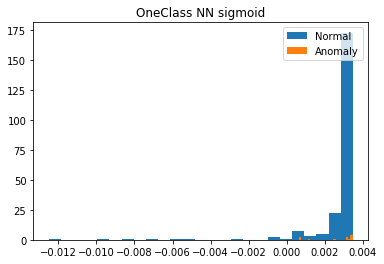

In [353]:
plt.hist(y_scores_pos_tf_OneClass_NN_sigmoid, bins = 25, label = 'Normal')
plt.hist(y_scores_neg_tf_OneClass_NN_sigmoid, bins = 25, label = 'Anomaly')
plt.title("OneClass NN sigmoid");
plt.legend(loc='upper right')
plt.show()